In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import tensorflow as tf

from keras import layers
from keras import models
from keras import utils
from keras.utils import to_categorical
from tensorflow import keras

# This tokenizer is nice, but could cause problems.
try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

%matplotlib inline

# Parameters

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# Data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# Encoded Tokens
preprocessed_corpus_path = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed.p')

indices_test_path = os.path.join(
    nlp_repo, 'data/03_processed/indices_test_path.p')

# Training parameters
train_anyway = False
model_path = "product_descr.h5"
#dataset_size = 500
epochs = 10
batch_size = 128
hidden_size = 1000

# Turning the Encoded Sequences into a Tensorflow Dataset

In [3]:
test_descr.head()

,Text_ID,Product_Description,Product_Type
0,5786,RT @mention Going to #SXSW? The new iPhone gui...,7
1,5363,RT @mention 95% of iPhone and Droid apps have ...,9
2,6716,RT @mention Thank you to @mention for letting ...,9
3,4339,#Thanks @mention we're lovin' the @mention app...,7
4,66,At #sxsw? @mention / @mention wanna buy you a ...,9


In [4]:
indices_train, vocabulary = pd.read_pickle(preprocessed_corpus_path)

In [5]:
indices_test, _ = pd.read_pickle(indices_test_path)

Sources:
* TF dataset: https://stackoverflow.com/questions/58362316/how-do-i-go-from-pandas-dataframe-to-tensorflow-batchdataset-for-nlp

In [6]:
train_descr_original = tf.keras.preprocessing.sequence.pad_sequences(
    indices_train, padding='post', value=len(vocabulary))
train_labels_original = train_descr['Sentiment'].to_numpy().flatten()

In [7]:
test_descr_original = tf.keras.preprocessing.sequence.pad_sequences(
    indices_test, padding='post', value=len(vocabulary))
# test_labels_original = test_descr['Sentiment'].to_numpy().flatten() #not given in the Test.csv

In [8]:
print(train_descr_original)
print(train_descr_original.shape)
print(train_labels_original)
print(test_descr_original)

[[ 154 3719  294 ... 7119 7119 7119]
 [   4    1   24 ... 7119 7119 7119]
 [ 451    6   22 ... 7119 7119 7119]
 ...
 [   4    1    4 ... 7119 7119 7119]
 [ 204  256   16 ... 7119 7119 7119]
 [   5   13 7118 ... 7119 7119 7119]]
(6364, 25)
[2 2 2 ... 2 2 2]
[[   4    1   21 ... 7119 7119 7119]
 [   4    1    7 ... 7119 7119 7119]
 [   4    1   73 ... 7119 7119 7119]
 ...
 [  64    5  184 ... 7119 7119 7119]
 [   4    1    0 ... 7119 7119 7119]
 [ 190    5   92 ... 7119 7119 7119]]


In [9]:
dimensions_descr = len(vocabulary)
dimensions_labels = len(set(train_descr['Sentiment']))

#### Train & Validation Split

In [10]:
split_index = int(0.8 * len(train_descr_original))

In [11]:
train_ds_original = tf.data.Dataset.from_tensor_slices(
    (train_descr_original[:split_index], train_labels_original[:split_index])).cache()

train_ds_emb = tf.data.Dataset.from_tensor_slices(
    (train_descr_original[:split_index], tf.one_hot(indices=train_labels_original[:split_index], depth=dimensions_labels))).cache()

In [12]:
validation_ds_original = tf.data.Dataset.from_tensor_slices(
    (train_descr_original[split_index:], train_labels_original[split_index:])).cache()

validation_ds_emb = tf.data.Dataset.from_tensor_slices(
    (train_descr_original[split_index:], tf.one_hot(indices=train_labels_original[split_index:], depth=dimensions_labels))).cache()

In [13]:
# test_ds_original = tf.data.Dataset.from_tensor_slices(
#    (test_descr_original[split_index:], test_labels_original[split_index:])).cache()

#### Transformation

#### Check, if transformation went ok

In [14]:
train_test_descr, train_test_label = list(train_ds_original.take(1))[0]

In [15]:
train_test_descr.numpy()

array([ 154, 3719,  294,  450,   17,   11,   18,    1,    2,    0, 7119,
       7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119, 7119,
       7119, 7119, 7119], dtype=int32)

In [16]:
train_test_label.numpy()  # .reshape(-1,).shape

2

In [17]:
train_test_descr_emb, train_test_label_emb = list(train_ds_emb.take(1))[0]

In [18]:
train_test_label_emb.numpy()

array([0., 0., 1., 0.], dtype=float32)

In [19]:
# ToDo: import from utils

In [20]:
def decode_indices(indices, vocabulary):
    """ Decodes a sequence of indices and returns a string. """
    # adding an extra item for padding in order to keep the decoding correct after padding
    # if we use the default value 0 for padding, it would be translated to one of our tokens
    vocabulary.append('padding')
    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

In [21]:
decoded_train_test_descr = decode_indices(train_test_descr, vocabulary)
decoded_train_test_descr

'web designeruas guide ios android app today mention link sxsw padding padding padding padding padding padding padding padding padding padding padding padding padding padding padding'

In [22]:
#test_test_descr = list(test_ds_original.take(1))[0]
#decoded_test_test_descr = decode_indices(test_test_descr, vocabulary)
# decoded_test_test_descr

# Bag-of-Words

* Bag-of-words will be used as a baseline model. 
* Its advantages are that it is fairly easy and quick to build. 
* The downside is that bag-of-words does not perserve the order of the sentence. As a result the structure of a sentence is lost. 
* RNNs & 1D ConvNets will be tried later in order to remedy this.

### One Hot Encoding

In [23]:
def one_hot_encode(indices, labels):
    indices = tf.dtypes.cast(indices, tf.int32)
    descr_encoded = tf.one_hot(indices=indices, depth=dimensions_descr)
    # takes the maximum in order to create one element
    descr_encoded = tf.reduce_max(descr_encoded, 0)

    label_encoded = tf.one_hot(indices=labels, depth=dimensions_labels)
    return descr_encoded, label_encoded

Compare before and after one-hot-encoding

In [24]:
random_descr_orig, random_label_orig = list(train_ds_original.take(1))[0]
print(random_descr_orig.shape)
print(random_descr_orig.numpy())
print(np.sum(random_descr_orig))
print(random_label_orig.numpy())

(25,)
[ 154 3719  294  450   17   11   18    1    2    0 7119 7119 7119 7119
 7119 7119 7119 7119 7119 7119 7119 7119 7119 7119 7119]
111451
2


In [25]:
train_ds = train_ds_original.map(
    lambda descr, label: one_hot_encode(descr, label)).cache()

validation_ds = validation_ds_original.map(
    lambda descr, label: one_hot_encode(descr, label)).cache()

# test_ds = test_ds_original.map(
#    lambda descr, label: one_hot_encode(descr, label)).cache()

In [26]:
random_descr, random_label = list(train_ds.take(1))[0]
print(random_descr.shape)
print(random_descr.numpy())
print(np.sum(random_descr))
print(random_label)
print(random_label.shape)

(7119,)
[1. 1. 1. ... 0. 0. 0.]
10.0
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
(4,)


In [27]:
random_descr_val, random_label_val = list(validation_ds.take(1))[0]
print(random_descr_val.shape)
print(random_descr_val.numpy())
print(np.sum(random_descr_val))
print(random_label_val)

(7119,)
[1. 1. 0. ... 0. 0. 0.]
15.0
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


# Fully Connected NN & Bag of Words

In [28]:
model = models.Sequential()

model.add(layers.Dense(16, activation='relu',
                       input_shape=(dimensions_descr, )))
model.add(layers.Dropout(0.75))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.75))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                113920    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 114,260
Trainable params: 114,260
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(
    train_ds.batch(32),
    epochs=20,
    validation_data=validation_ds.batch(32)
)

Epoch 1/20
160/160 [==============================] - 1s 6ms/step - loss: 1.2586 - accuracy: 0.4645 - val_loss: 1.0719 - val_accuracy: 0.5766
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 1.0599 - accuracy: 0.5402 - val_loss: 0.9445 - val_accuracy: 0.5766
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9827 - accuracy: 0.5730 - val_loss: 0.9206 - val_accuracy: 0.5766
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.9539 - accuracy: 0.5877 - val_loss: 0.9081 - val_accuracy: 0.5766
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9350 - accuracy: 0.5948 - val_loss: 0.8999 - val_accuracy: 0.5766
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9184 - accuracy: 0.5969 - val_loss: 0.8900 - val_accuracy: 0.5766
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.9073 - accuracy: 0.6028 - val_loss: 0.8830 - val_accuracy: 0.5766
Epoch 

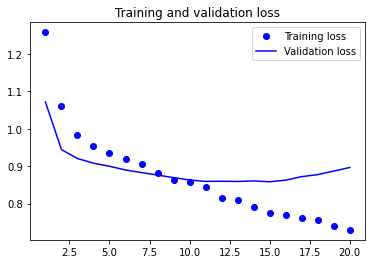

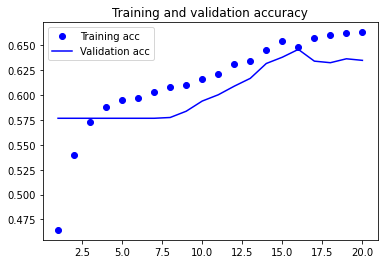

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Embeddings Layer

In [31]:
vocabulary_size = len(vocabulary)
embedding_size = 8
sequence_length = np.max([len(x) for x in indices_train])

In [32]:
model_emb = models.Sequential()

model_emb.add(layers.Embedding(vocabulary_size,
                               embedding_size, input_length=sequence_length))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(16, activation='relu'))
model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(16, activation='relu'))
model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(4, activation='softmax'))

model_emb.summary()

model_emb.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 8)             56960     
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                3216      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [33]:
history_emb = model_emb.fit(
    train_ds_emb.shuffle(100).batch(32),
    epochs=20,
    validation_data=validation_ds_emb.batch(32)
)

Epoch 1/20
160/160 [==============================] - 0s 2ms/step - loss: 1.2246 - accuracy: 0.5158 - val_loss: 1.0508 - val_accuracy: 0.5766
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 1.0616 - accuracy: 0.5763 - val_loss: 0.9664 - val_accuracy: 0.5766
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9972 - accuracy: 0.5954 - val_loss: 0.9443 - val_accuracy: 0.5766
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9604 - accuracy: 0.5956 - val_loss: 0.9334 - val_accuracy: 0.5766
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9324 - accuracy: 0.5954 - val_loss: 0.9209 - val_accuracy: 0.5766
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.8972 - accuracy: 0.5952 - val_loss: 0.9069 - val_accuracy: 0.5766
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.8522 - accuracy: 0.5967 - val_loss: 0.9066 - val_accuracy: 0.5766
Epoch 

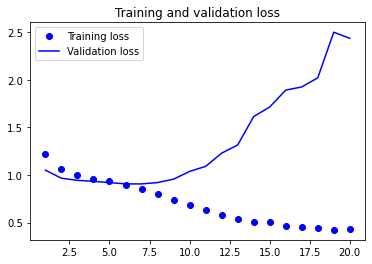

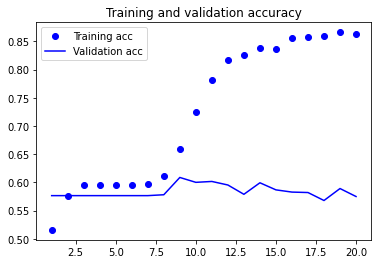

In [34]:
loss_emb = history_emb.history['loss']
val_loss_emb = history_emb.history['val_loss']
acc_emb = history_emb.history['accuracy']
val_acc_emb = history_emb.history['val_accuracy']


epochs = range(1, len(acc_emb) + 1)

plt.plot(epochs, loss_emb, 'bo', label='Training loss')
plt.plot(epochs, val_loss_emb, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc_emb, 'bo', label='Training acc')
plt.plot(epochs, val_acc_emb, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Pre-Trained Embeddings Layer

In [35]:
glove_dir = './glove.6B'

In [36]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [37]:
embedding_dim = 100

In [38]:
# note that index 0 is reserved, never assigned to an existing word
word_index = dict(zip(vocabulary, list(range(1, vocabulary_size + 1))))
# word_index

In [39]:
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in word_index.items():
    if i < len(vocabulary):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(7120, 100)


In [40]:
model_transf = models.Sequential()

model_transf.add(layers.Embedding(vocabulary_size,
                                  embedding_dim, input_length=sequence_length))

model_transf.add(layers.Flatten())
model_transf.add(layers.Dense(16, activation='relu'))
model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(16, activation='relu'))
model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(4, activation='softmax'))

model_transf.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_transf.layers[0].trainable = False

model_transf.summary()

model_transf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           712000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                40016     
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

In [41]:
history_transf = model_transf.fit(
    train_ds_emb.shuffle(100).batch(32),
    epochs=20,
    validation_data=validation_ds_emb.batch(32)
)

Epoch 1/20
160/160 [==============================] - 0s 2ms/step - loss: 1.2799 - accuracy: 0.5135 - val_loss: 1.1317 - val_accuracy: 0.5766
Epoch 2/20
160/160 [==============================] - 0s 1ms/step - loss: 1.1046 - accuracy: 0.5549 - val_loss: 1.0158 - val_accuracy: 0.5766
Epoch 3/20
160/160 [==============================] - 0s 1ms/step - loss: 1.0363 - accuracy: 0.5891 - val_loss: 0.9728 - val_accuracy: 0.5766
Epoch 4/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9988 - accuracy: 0.5932 - val_loss: 0.9561 - val_accuracy: 0.5766
Epoch 5/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9853 - accuracy: 0.5950 - val_loss: 0.9494 - val_accuracy: 0.5766
Epoch 6/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9761 - accuracy: 0.5967 - val_loss: 0.9464 - val_accuracy: 0.5766
Epoch 7/20
160/160 [==============================] - 0s 1ms/step - loss: 0.9605 - accuracy: 0.5956 - val_loss: 0.9440 - val_accuracy: 0.5766
Epoch 

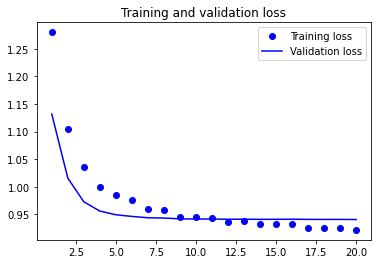

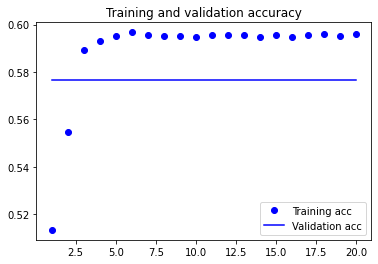

In [42]:
loss_transf = history_transf.history['loss']
val_loss_transf = history_transf.history['val_loss']
acc_transf = history_transf.history['accuracy']
val_acc_transf = history_transf.history['val_accuracy']


epochs = range(1, len(acc_emb) + 1)

plt.plot(epochs, loss_transf, 'bo', label='Training loss')
plt.plot(epochs, val_loss_transf, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc_transf, 'bo', label='Training acc')
plt.plot(epochs, val_acc_transf, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# LSTM

In [43]:
model_lstm = models.Sequential()

model_lstm.add(layers.Embedding(vocabulary_size,
                                embedding_dim, input_length=sequence_length))

# model_lstm.add(layers.Flatten())
# Option 1
model_lstm.add(layers.LSTM(32))

# Option 2
# model.add(layers.LSTM(32, return_sequences=True)) # stacking of LSTMs
# model.add(layers.LSTM(32)) # the size of the hidden state, randomly defined
model_lstm.add(layers.Dense(16, activation='relu'))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(16, activation='relu'))
model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(4, activation='softmax'))

model_lstm.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_lstm.layers[0].trainable = False

model_lstm.summary()

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           712000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                

In [44]:
history_lstm = model_lstm.fit(
    train_ds_emb.shuffle(100).batch(32),
    epochs=20,
    validation_data=validation_ds_emb.batch(32)
)

Epoch 1/20
160/160 [==============================] - 2s 10ms/step - loss: 1.1516 - accuracy: 0.4716 - val_loss: 0.9689 - val_accuracy: 0.5766
Epoch 2/20
160/160 [==============================] - 1s 9ms/step - loss: 1.0058 - accuracy: 0.5696 - val_loss: 0.9270 - val_accuracy: 0.5766
Epoch 3/20
160/160 [==============================] - 1s 8ms/step - loss: 0.9579 - accuracy: 0.5885 - val_loss: 0.9196 - val_accuracy: 0.5766
Epoch 4/20
160/160 [==============================] - 1s 8ms/step - loss: 0.9289 - accuracy: 0.5952 - val_loss: 0.9113 - val_accuracy: 0.5766
Epoch 5/20
160/160 [==============================] - 1s 8ms/step - loss: 0.9146 - accuracy: 0.5952 - val_loss: 0.9051 - val_accuracy: 0.5766
Epoch 6/20
160/160 [==============================] - 1s 7ms/step - loss: 0.9018 - accuracy: 0.5950 - val_loss: 0.9058 - val_accuracy: 0.5766
Epoch 7/20
160/160 [==============================] - 1s 8ms/step - loss: 0.8997 - accuracy: 0.5946 - val_loss: 0.8939 - val_accuracy: 0.5766
Epoch

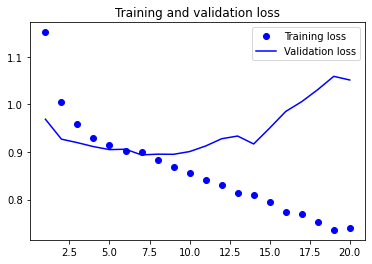

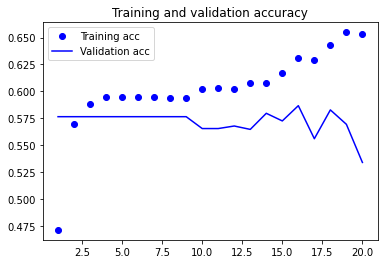

In [45]:
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']
acc_lstm = history_lstm.history['accuracy']
val_acc_lstm = history_lstm.history['val_accuracy']


epochs = range(1, len(acc_lstm) + 1)

plt.plot(epochs, loss_lstm, 'bo', label='Training loss')
plt.plot(epochs, val_loss_lstm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc_lstm, 'bo', label='Training acc')
plt.plot(epochs, val_acc_lstm, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# 1D Convolutional NN

In [46]:
model_conv1d = models.Sequential()

model_conv1d.add(layers.Embedding(vocabulary_size,
                                  embedding_dim, input_length=sequence_length))

model_conv1d.add(layers.Conv1D(
    32,  # features to be extracted
    5,  # convolutional window size
    activation='relu',
))
model_conv1d.add(layers.MaxPooling1D(3))
model_conv1d.add(layers.Conv1D(32, 5, activation='relu'))
model_conv1d.add(layers.GlobalMaxPooling1D())
model_conv1d.add(layers.Dense(4, activation='softmax'))

model_conv1d.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_conv1d.layers[0].trainable = False

model_conv1d.summary()

model_conv1d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 100)           712000    
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 32)            16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 32)             5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 132       
Total params: 733,316
Trainable params: 21,316
Non-trainable params: 712,000
___________________________________________

In [47]:
history_conv1d = model_conv1d.fit(
    train_ds_emb.shuffle(100).batch(32),
    epochs=20,
    validation_data=validation_ds_emb.batch(32)
)

Epoch 1/20
160/160 [==============================] - 0s 3ms/step - loss: 0.9345 - accuracy: 0.5865 - val_loss: 0.9161 - val_accuracy: 0.5766
Epoch 2/20
160/160 [==============================] - 0s 2ms/step - loss: 0.8510 - accuracy: 0.6166 - val_loss: 0.9140 - val_accuracy: 0.5687
Epoch 3/20
160/160 [==============================] - 0s 2ms/step - loss: 0.7930 - accuracy: 0.6494 - val_loss: 0.9005 - val_accuracy: 0.5899
Epoch 4/20
160/160 [==============================] - 0s 2ms/step - loss: 0.7244 - accuracy: 0.6999 - val_loss: 0.9055 - val_accuracy: 0.5915
Epoch 5/20
160/160 [==============================] - 0s 2ms/step - loss: 0.6452 - accuracy: 0.7468 - val_loss: 0.9394 - val_accuracy: 0.5892
Epoch 6/20
160/160 [==============================] - 0s 2ms/step - loss: 0.5683 - accuracy: 0.7782 - val_loss: 0.9873 - val_accuracy: 0.5939
Epoch 7/20
160/160 [==============================] - 0s 2ms/step - loss: 0.4921 - accuracy: 0.8163 - val_loss: 1.0228 - val_accuracy: 0.5703
Epoch 

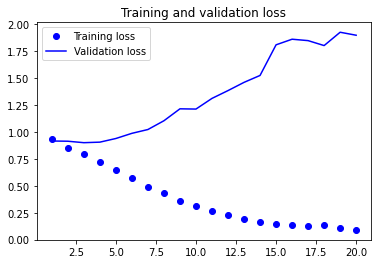

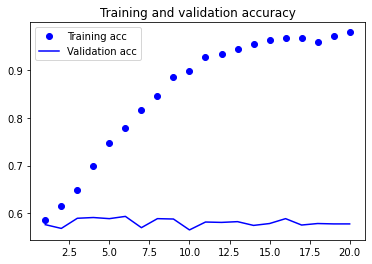

In [48]:
loss_conv1d= history_conv1d.history['loss']
val_loss_conv1d = history_conv1d.history['val_loss']
acc_conv1d = history_conv1d.history['accuracy']
val_acc_conv1d = history_conv1d.history['val_accuracy']


epochs = range(1, len(acc_conv1d) + 1)

plt.plot(epochs, loss_conv1d, 'bo', label='Training loss')
plt.plot(epochs, val_loss_conv1d, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc_conv1d, 'bo', label='Training acc')
plt.plot(epochs, val_acc_conv1d, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()